> __Paper:__
Physics-informed neural networks: A deep learning framework for solving forward and
inverse problems involving nonlinear partial differential equations

> [Link](https://doi.org/10.1016/j.jcp.2018.10.045)

> In This notebook, estimate the parameters.

> We select the last 32 time steps of a 32 x 32 grid of a solution of ASDM. The Training dataset includes all grid's data point.

> The free parameters of the model are fixed.

> The goal here is overfitting the model to re-create the exact output from the mtrained model. Therefore, we can be sure about the code and the selected architecture.

In [2]:
"""
@author: Maziar Raissi
"""

import sys
sys.path.insert(0, '../../clones/PINNs/Utilities/')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
#from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable


import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
#os.environ["CUDA_VISIBLE_DEVICES"]="1"
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#tf.logging.set_verbosity(tf.logging.ERROR)

In [109]:
np.random.seed(1234)
tf.set_random_seed(1234)


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x, y, t, a, s, layers): 
        
        with tf.device('gpu:0'):
        #with tf.device('cpu:0'):
                 
            X = np.concatenate([x, y, t], 1)

            self.lb = X.min(0)
            self.ub = X.max(0)                        

            self.x = X[:,0:1]
            self.y = X[:,1:2]
            self.t = X[:,2:3]

            self.a = a
            self.s = s

            self.layers = layers

            # Initialize NN
            self.weights, self.biases = self.initialize_NN(layers)        

            # Initialize parameters
            self.D_a = tf.Variable([1.0], dtype=tf.float32, 
                                   name="D_a", 
                                   constraint= lambda z: tf.clip_by_value(z, 1e-10, 1e10))#tf.constant(0.005, dtype=tf.float32)#
            self.D_s = tf.Variable([1.0], dtype=tf.float32, 
                                   name="D_s",
                                  constraint= lambda z: tf.clip_by_value(z, 1e-10, 1e10))#tf.constant(0.2, dtype=tf.float32)#
            self.sigma_a = tf.constant(0.0, dtype=tf.float32, name="sigma_a")#tf.Variable([0.0], dtype=tf.float32)#
            self.sigma_s = tf.Variable([1.00], dtype=tf.float32, 
                                       name="sigma_s",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.02, dtype=tf.float32)#
            self.mu_a = tf.Variable([1.00], dtype=tf.float32, 
                                    name="mu_a",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.01, dtype=tf.float32)#
            self.rho_a = tf.Variable([1.00], dtype=tf.float32, 
                                     name="rho_a",
                                    constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.01, dtype=tf.float32)#
            self.rho_s = tf.Variable([1.00], dtype=tf.float32, 
                                     name="rho_s",
                                    constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.02, dtype=tf.float32)#
            self.kappa_a = tf.constant(0.25, dtype=tf.float32)#tf.Variable([1.00], dtype=tf.float32,name="kappa_a")#

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]], name="x_tf")
        self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]], name="y_tf")
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]], name="t_tf")

        self.a_tf = tf.placeholder(tf.float32, shape=[None, self.a.shape[1]], name="a_tf")
        self.s_tf = tf.placeholder(tf.float32, shape=[None, self.s.shape[1]], name="s_tf")

        self.a_pred, self.s_pred, self.f_a_pred, self.f_s_pred = self.net_ASDM(self.x_tf, self.y_tf, self.t_tf)

        self.loss_1 = tf.reduce_sum(tf.square(self.a_tf - self.a_pred)) + \
                    tf.reduce_sum(tf.square(self.s_tf - self.s_pred)) 

        self.loss_a = tf.reduce_sum(tf.square(self.f_a_pred), name = "loss_a")

        self.loss_s = tf.reduce_sum(tf.square(self.f_s_pred), name = "loss_s")

        self.loss = self.loss_1 + self.loss_a + self.loss_s        

        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        

        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
            #H = tf.nn.relu(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
        
    def net_ASDM(self, x, y, t):
        D_a = self.D_a
        D_s = self.D_s
        sigma_a = self.sigma_a
        sigma_s = self.sigma_s
        mu_a = self.mu_a
        rho_a = self.rho_a
        rho_s = self.rho_s
        kappa_a = self.kappa_a
        
        a_and_s = self.neural_net(tf.concat([x,y,t], 1), self.weights, self.biases)
        #a = a_and_s[:,0:1]
        a = tf.slice(a_and_s, [0,0], [-1,1], name = "a_pred")
        #s = a_and_s[:,1:2]                
        s = tf.slice(a_and_s, [0,1], [-1,1], name = "s_pred")
        
        a_t = tf.gradients(a, t)[0]
        a_x = tf.gradients(a, x)[0]
        a_y = tf.gradients(a, y)[0]
        a_xx = tf.gradients(a_x, x)[0]
        a_yy = tf.gradients(a_y, y)[0]
        
        s_t = tf.gradients(s, t)[0]
        s_x = tf.gradients(s, x)[0]
        s_y = tf.gradients(s, y)[0]
        s_xx = tf.gradients(s_x, x)[0]
        s_yy = tf.gradients(s_y, y)[0]
        
        f = a*a*s/(1 + kappa_a*a*a)
        f_a = a_t - D_a*(a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
        f_s = s_t - D_s*(s_xx + s_yy) + rho_s*f - sigma_s
        
        return a, s, f_a, f_s
    
    def callback(self, loss, loss_a, loss_s, D_a, D_s, sigma_a,sigma_s,
                       rho_a, rho_s, mu_a, kappa_a):
        print(f"loss: {loss.tolist()}, loss_a: {loss_a.tolist()}, loss_s: {loss_s.tolist()},\n"
              f"D_a: {D_a.tolist()}, D_s: {D_s.tolist()}\n"
              f"sigma_a: {sigma_a.tolist()}, sigma_s: {sigma_s.tolist()}\n"
              f"rho_a: {rho_a.tolist()}, rho_s: {rho_s.tolist()}\n"
              f"mu_a: {mu_a.tolist()}, kappa_a: {kappa_a.tolist()}\n")
        
      
    def train(self, nIter, early_stop_thresh = None, print_iter = 100): 

        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.a_tf: self.a, self.s_tf: self.s}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            loss_value = self.sess.run(self.loss, tf_dict)
            # Print
            if it % print_iter == 0:
                elapsed = time.time() - start_time
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                #loss_value = self.sess.run(self.loss, tf_dict)
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                sigma_a_value = self.sess.run(self.sigma_a)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                print(f"It: {it}, loss_a  : {loss_a_value:.8f}, loss_s  : {loss_s_value:.8f}, loss  : {loss_value:.2f},\n"
                      f"D_a: {D_a_value.tolist()}, D_s: {D_s_value.tolist()}\n"
                      f"sigma_a: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a: {rho_a_value.tolist()}, rho_s: {rho_s_value.tolist()}\n"
                      f"mu_a: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                
            if early_stop_thresh is not None and early_stop_thresh >= loss_value:
                print("#"*50)
                print("         Early stop")
                print("#"*50)
                elapsed = time.time() - start_time
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                #loss_value = self.sess.run(self.loss, tf_dict)
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                sigma_a_value = self.sess.run(self.sigma_a)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                print(f"It: {it}, loss_a  : {loss_a_value:.8f}, loss_s  : {loss_s_value:.8f}, loss  : {loss_value:.2f},\n"
                      f"D_a: {D_a_value.tolist()}, D_s: {D_s_value.tolist()}\n"
                      f"sigma_a: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a: {rho_a_value.tolist()}, rho_s: {rho_s_value.tolist()}\n"
                      f"mu_a: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                break
                
            
        
        
    def minimise(self, max_iter = None, f_tol = None):
        if max_iter is not None:
            self.optimizer.optimizer_kwargs['options']['maxiter'] = max_iter
            
        if f_tol is not None:
            self.optimizer.optimizer_kwargs['options']['f_tol'] = f_tol
        
        
        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.a_tf: self.a, self.s_tf: self.s}
            
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.loss_a, self.loss_s,
                                           self.D_a, self.D_s,
                                          self.sigma_a, self.sigma_s,
                                          self.rho_a, self.rho_s,
                                          self.mu_a, self.kappa_a],
                                loss_callback = self.callback)
            
    
    def predict(self, x_star, y_star, t_star):
        
        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}
        
        a_star = self.sess.run(self.a_pred, tf_dict)
        s_star = self.sess.run(self.s_pred, tf_dict)
        
        return a_star, s_star

In [110]:
#layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]
layers = [3, 64, 64, 64, 64, 2]
#layers = [3, 128, 128, 128, 128, 2]

#layers = [3, 100, 100, 100, 100, 2]

# Load Data
import os
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = 32#10#t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size
x = L*np.linspace(0,1,x_size)
y = L*np.linspace(0,1,y_size)

X,Y = np.meshgrid(x, y, sparse=False, indexing='ij')
XX = np.tile(X.flatten(), T) # N x T
YY = np.tile(Y.flatten(), T) # N x T
TT = np.repeat(t_star[-T:], N) # T x N

AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


x = XX[:, np.newaxis] # NT x 1
y = YY[:, np.newaxis] # NT x 1
t = TT[:, np.newaxis] # NT x 1

a = AA[:, np.newaxis] # NT x 1
s = SS[:, np.newaxis] # NT x 1

######################################################################
######################## Noiseles Data ###############################
######################################################################
# Training Data    
#idx = np.random.choice(N*T, N_train, replace=False)
#idx = np.random.choice(N*T, T*32, replace=False)
idx = list(range(N*T))
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
a_train = a[idx,:]
s_train = s[idx,:]




In [111]:
# Training
model = PhysicsInformedNN(x_train, y_train, t_train, a_train, s_train, layers)
model.train(10000, early_stop_thresh=10000.0, print_iter=100)

It: 0, loss_a  : 6.78763103, loss_s  : 32702.39843750, loss  : 125928.44,
D_a: [0.9990000128746033], D_s: [0.9990001320838928]
sigma_a: 0.0, sigma_s: [0.9990000128746033]
rho_a: [0.9990000128746033], rho_s: [0.9990000128746033]
mu_a: [0.9990000128746033], kappa_a: 0.25, 
Time:4.51

##################################################
         Early stop
##################################################
It: 53, loss_a  : 12.97238636, loss_s  : 44.13793564, loss  : 9989.41,
D_a: [0.987143874168396], D_s: [1.0201927423477173]
sigma_a: 0.0, sigma_s: [0.9737921953201294]
rho_a: [0.9990737438201904], rho_s: [1.0083167552947998]
mu_a: [0.9871810674667358], kappa_a: 0.25, 
Time:53.53



In [112]:
model.train(10000, early_stop_thresh=1000.0, print_iter=100)

It: 0, loss_a  : 33.21915054, loss_s  : 93.64644623, loss  : 10034.37,
D_a: [0.9870442748069763], D_s: [1.0202624797821045]
sigma_a: 0.0, sigma_s: [0.9737198352813721]
rho_a: [0.999121904373169], rho_s: [1.0083537101745605]
mu_a: [0.9870617985725403], kappa_a: 0.25, 
Time:1.02

It: 100, loss_a  : 9.56508923, loss_s  : 29.53379440, loss  : 9955.33,
D_a: [0.9926875233650208], D_s: [1.015123963356018]
sigma_a: 0.0, sigma_s: [0.9755918979644775]
rho_a: [0.994056761264801], rho_s: [1.0012249946594238]
mu_a: [0.9920216798782349], kappa_a: 0.25, 
Time:100.86

It: 200, loss_a  : 7.48980331, loss_s  : 23.08287811, loss  : 9938.48,
D_a: [0.9965462684631348], D_s: [1.0092495679855347]
sigma_a: 0.0, sigma_s: [0.9785907864570618]
rho_a: [0.9910495281219482], rho_s: [0.9927688241004944]
mu_a: [0.9952067136764526], kappa_a: 0.25, 
Time:100.99

It: 300, loss_a  : 6.13348198, loss_s  : 18.57577705, loss  : 9927.32,
D_a: [0.9996638894081116], D_s: [1.0044642686843872]
sigma_a: 0.0, sigma_s: [0.981340885

It: 3000, loss_a  : 0.90164638, loss_s  : 7.98403358, loss  : 9881.04,
D_a: [1.3575540781021118], D_s: [0.9957906603813171]
sigma_a: 0.0, sigma_s: [0.9799946546554565]
rho_a: [0.9786795973777771], rho_s: [0.9606178402900696]
mu_a: [0.9978854656219482], kappa_a: 0.25, 
Time:100.82

It: 3100, loss_a  : 1.13258362, loss_s  : 8.60939407, loss  : 9873.92,
D_a: [1.4570642709732056], D_s: [0.9246460199356079]
sigma_a: 0.0, sigma_s: [0.9793844223022461]
rho_a: [0.9784762859344482], rho_s: [0.9599800705909729]
mu_a: [0.997605562210083], kappa_a: 0.25, 
Time:100.88

It: 3200, loss_a  : 1.11765647, loss_s  : 12.46453476, loss  : 9869.68,
D_a: [1.580346703529358], D_s: [0.8069265484809875]
sigma_a: 0.0, sigma_s: [0.9783657789230347]
rho_a: [0.978011965751648], rho_s: [0.9589186310768127]
mu_a: [0.9970232248306274], kappa_a: 0.25, 
Time:100.89

It: 3300, loss_a  : 1.64011335, loss_s  : 10.88969231, loss  : 9865.86,
D_a: [1.7059193849563599], D_s: [0.6611497402191162]
sigma_a: 0.0, sigma_s: [0.97739

It: 5900, loss_a  : 1.45951295, loss_s  : 11.56884384, loss  : 9850.91,
D_a: [3.820755958557129], D_s: [1.000000013351432e-10]
sigma_a: 0.0, sigma_s: [0.9224714636802673]
rho_a: [0.9586466550827026], rho_s: [0.9043904542922974]
mu_a: [0.9771215915679932], kappa_a: 0.25, 
Time:100.84

It: 6000, loss_a  : 1.51973319, loss_s  : 12.29780006, loss  : 9846.71,
D_a: [3.8520307540893555], D_s: [1.000000013351432e-10]
sigma_a: 0.0, sigma_s: [0.9186046719551086]
rho_a: [0.9571971893310547], rho_s: [0.9006249308586121]
mu_a: [0.9755818247795105], kappa_a: 0.25, 
Time:100.77

It: 6100, loss_a  : 2.32735229, loss_s  : 12.30143452, loss  : 9840.60,
D_a: [3.868109941482544], D_s: [1.000000013351432e-10]
sigma_a: 0.0, sigma_s: [0.9146605134010315]
rho_a: [0.9558122158050537], rho_s: [0.8967140913009644]
mu_a: [0.974092423915863], kappa_a: 0.25, 
Time:100.74

It: 6200, loss_a  : 5.65940666, loss_s  : 33.58337021, loss  : 9850.49,
D_a: [3.8518083095550537], D_s: [4.046066533192061e-05]
sigma_a: 0.0, sig

It: 8800, loss_a  : 17.09745026, loss_s  : 104.53816223, loss  : 9092.33,
D_a: [0.0918123796582222], D_s: [1.866391658782959]
sigma_a: 0.0, sigma_s: [0.6690597534179688]
rho_a: [0.9093968868255615], rho_s: [0.6554328203201294]
mu_a: [0.9201412200927734], kappa_a: 0.25, 
Time:100.87

It: 8900, loss_a  : 23.51144409, loss_s  : 109.75109100, loss  : 8902.21,
D_a: [0.07461604475975037], D_s: [1.811295509338379]
sigma_a: 0.0, sigma_s: [0.6418421864509583]
rho_a: [0.9038492441177368], rho_s: [0.6295670866966248]
mu_a: [0.9128751754760742], kappa_a: 0.25, 
Time:100.87

It: 9000, loss_a  : 26.13216019, loss_s  : 113.19840240, loss  : 8627.94,
D_a: [0.10872778296470642], D_s: [1.9870836734771729]
sigma_a: 0.0, sigma_s: [0.6104184985160828]
rho_a: [0.89702969789505], rho_s: [0.5991153717041016]
mu_a: [0.9048641920089722], kappa_a: 0.25, 
Time:100.79

It: 9100, loss_a  : 27.68552017, loss_s  : 129.75372314, loss  : 8331.04,
D_a: [0.16382262110710144], D_s: [2.1999614238739014]
sigma_a: 0.0, sigma

In [113]:
model.train(20000, early_stop_thresh=1000.0, print_iter=100)

It: 0, loss_a  : 64.33843994, loss_s  : 29.13691330, loss  : 2029.56,
D_a: [0.3179663419723511], D_s: [0.9577409625053406]
sigma_a: 0.0, sigma_s: [0.11070041358470917]
rho_a: [0.7589640021324158], rho_s: [0.10866640508174896]
mu_a: [0.7638015747070312], kappa_a: 0.25, 
Time:1.01

It: 100, loss_a  : 62.94252014, loss_s  : 18.53244591, loss  : 1339.33,
D_a: [0.30080869793891907], D_s: [0.755902886390686]
sigma_a: 0.0, sigma_s: [0.08696333318948746]
rho_a: [0.733711838722229], rho_s: [0.08551342040300369]
mu_a: [0.7372832894325256], kappa_a: 0.25, 
Time:100.93

##################################################
         Early stop
##################################################
It: 182, loss_a  : 61.28741455, loss_s  : 12.76417160, loss  : 996.91,
D_a: [0.2910175323486328], D_s: [0.6273471117019653]
sigma_a: 0.0, sigma_s: [0.07139617204666138]
rho_a: [0.7117050886154175], rho_s: [0.07012082636356354]
mu_a: [0.7148438096046448], kappa_a: 0.25, 
Time:82.92



In [ ]:
model.train(20000, early_stop_thresh=100.0, print_iter=100)

It: 0, loss_a  : 61.08857727, loss_s  : 12.77725410, loss  : 993.21,
D_a: [0.2907891571521759], D_s: [0.6259530782699585]
sigma_a: 0.0, sigma_s: [0.07122017443180084]
rho_a: [0.7114284038543701], rho_s: [0.06995057314634323]
mu_a: [0.7145759463310242], kappa_a: 0.25, 
Time:1.01

It: 100, loss_a  : 55.90189362, loss_s  : 7.68375301, loss  : 787.32,
D_a: [0.2817917466163635], D_s: [0.5039648413658142]
sigma_a: 0.0, sigma_s: [0.05556337535381317]
rho_a: [0.6833602786064148], rho_s: [0.05458448827266693]
mu_a: [0.687020480632782], kappa_a: 0.25, 
Time:100.97

It: 200, loss_a  : 51.71371078, loss_s  : 4.68185806, loss  : 650.78,
D_a: [0.2749430537223816], D_s: [0.4075922667980194]
sigma_a: 0.0, sigma_s: [0.04392491653561592]
rho_a: [0.6555055379867554], rho_s: [0.043203167617321014]
mu_a: [0.659207284450531], kappa_a: 0.25, 
Time:100.82

It: 300, loss_a  : 46.20249176, loss_s  : 2.88173842, loss  : 550.63,
D_a: [0.2673775553703308], D_s: [0.3313694894313812]
sigma_a: 0.0, sigma_s: [0.035082

In [129]:
model.train(20000, early_stop_thresh=10.0, print_iter=100)

It: 0, loss_a  : 1.22993469, loss_s  : 0.00000060, loss  : 99.93,
D_a: [0.05835762992501259], D_s: [0.0001936204789672047]
sigma_a: 0.0, sigma_s: [1.8912103769253008e-05]
rho_a: [0.12248393893241882], rho_s: [1.8672442820388824e-05]
mu_a: [0.12306059896945953], kappa_a: 0.25, 
Time:1.01

It: 100, loss_a  : 1.00007367, loss_s  : 0.00000025, loss  : 97.61,
D_a: [0.05277419462800026], D_s: [0.00012108655937481672]
sigma_a: 0.0, sigma_s: [1.1838035788969137e-05]
rho_a: [0.11055808514356613], rho_s: [1.1675776477204636e-05]
mu_a: [0.11107738316059113], kappa_a: 0.25, 
Time:100.95

It: 200, loss_a  : 0.78692931, loss_s  : 0.00000011, loss  : 98.34,
D_a: [0.047331903129816055], D_s: [7.396795990644023e-05]
sigma_a: 0.0, sigma_s: [7.240850209200289e-06]
rho_a: [0.09917673468589783], rho_s: [7.130693575163605e-06]
mu_a: [0.09964305907487869], kappa_a: 0.25, 
Time:100.81

It: 300, loss_a  : 0.63406289, loss_s  : 0.00000006, loss  : 93.77,
D_a: [0.04231772571802139], D_s: [4.4379841710906476e-05]

It: 2800, loss_a  : 0.00001069, loss_s  : 0.00000003, loss  : 63.99,
D_a: [0.00018459813145454973], D_s: [1.3424578355625272e-06]
sigma_a: 0.0, sigma_s: [1.648827065992009e-07]
rho_a: [0.0003800150298047811], rho_s: [1.40689948580075e-07]
mu_a: [0.0003816814860329032], kappa_a: 0.25, 
Time:100.94

It: 2900, loss_a  : 0.00000517, loss_s  : 0.00000003, loss  : 64.58,
D_a: [0.00011964768054895103], D_s: [1.3452449820761103e-06]
sigma_a: 0.0, sigma_s: [1.4554439076164272e-07]
rho_a: [0.00026103691197931767], rho_s: [1.3079043981178984e-07]
mu_a: [0.00026327994419261813], kappa_a: 0.25, 
Time:100.87

It: 3000, loss_a  : 0.00000243, loss_s  : 0.00000002, loss  : 62.24,
D_a: [8.555466047255322e-05], D_s: [1.3100529940857086e-06]
sigma_a: 0.0, sigma_s: [1.623512559945084e-07]
rho_a: [0.0001759421284077689], rho_s: [1.3769528095508576e-07]
mu_a: [0.0001766993518685922], kappa_a: 0.25, 
Time:100.94

It: 3100, loss_a  : 0.00000120, loss_s  : 0.00000003, loss  : 65.88,
D_a: [5.646801946568303e-05]

It: 5600, loss_a  : 0.00000023, loss_s  : 0.00000002, loss  : 44.75,
D_a: [5.839941081831057e-07], D_s: [1.7394437463735812e-06]
sigma_a: 0.0, sigma_s: [2.2772617569444265e-07]
rho_a: [1.131679596255708e-06], rho_s: [1.8045876970518293e-07]
mu_a: [1.2061583447575686e-06], kappa_a: 0.25, 
Time:101.00

It: 5700, loss_a  : 0.00000085, loss_s  : 0.00000002, loss  : 44.59,
D_a: [1.000000013351432e-10], D_s: [1.6299064782288042e-06]
sigma_a: 0.0, sigma_s: [2.2452979919762583e-07]
rho_a: [3.805874939644127e-06], rho_s: [1.6220928955590352e-07]
mu_a: [1.1015413292625453e-07], kappa_a: 0.25, 
Time:100.83

It: 5800, loss_a  : 0.00103853, loss_s  : 0.00000002, loss  : 43.70,
D_a: [0.00015037284174468368], D_s: [1.7636771190154832e-06]
sigma_a: 0.0, sigma_s: [2.3403194404636452e-07]
rho_a: [0.0], rho_s: [1.814496215502004e-07]
mu_a: [0.00014278292655944824], kappa_a: 0.25, 
Time:100.86

It: 5900, loss_a  : 0.00003711, loss_s  : 0.00000002, loss  : 46.09,
D_a: [4.019876359961927e-05], D_s: [1.21125

It: 8500, loss_a  : 0.00005675, loss_s  : 0.00000007, loss  : 32.52,
D_a: [1.000000013351432e-10], D_s: [7.341147920669755e-06]
sigma_a: 0.0, sigma_s: [0.0]
rho_a: [5.470191899803467e-05], rho_s: [1.1174059864060837e-06]
mu_a: [2.0773881260538474e-05], kappa_a: 0.25, 
Time:100.88

It: 8600, loss_a  : 0.00000879, loss_s  : 0.00000595, loss  : 32.60,
D_a: [3.67488173651509e-05], D_s: [1.7868351278593764e-05]
sigma_a: 0.0, sigma_s: [1.3466117707139347e-05]
rho_a: [3.50316331605427e-05], rho_s: [0.0]
mu_a: [4.736477785627358e-05], kappa_a: 0.25, 
Time:101.09

It: 8700, loss_a  : 0.00010250, loss_s  : 0.00000002, loss  : 31.98,
D_a: [4.726647603092715e-06], D_s: [1.000000013351432e-10]
sigma_a: 0.0, sigma_s: [3.8567264937228174e-08]
rho_a: [7.136099156923592e-05], rho_s: [0.0]
mu_a: [2.5189045118167996e-05], kappa_a: 0.25, 
Time:100.82

It: 8800, loss_a  : 0.00018295, loss_s  : 0.00000049, loss  : 34.62,
D_a: [1.000000013351432e-10], D_s: [1.4867657228023745e-05]
sigma_a: 0.0, sigma_s: [3.7

It: 11500, loss_a  : 0.00003004, loss_s  : 0.00000002, loss  : 24.43,
D_a: [4.281309884390794e-05], D_s: [1.000000013351432e-10]
sigma_a: 0.0, sigma_s: [4.696276789672993e-08]
rho_a: [3.26587978634052e-05], rho_s: [0.0]
mu_a: [5.6836724979802966e-05], kappa_a: 0.25, 
Time:100.85

It: 11600, loss_a  : 0.00022520, loss_s  : 0.00000012, loss  : 24.26,
D_a: [4.625545261660591e-05], D_s: [1.0028157703345641e-05]
sigma_a: 0.0, sigma_s: [0.0]
rho_a: [3.6658457247540355e-07], rho_s: [1.6033840211093775e-06]
mu_a: [6.93207184667699e-05], kappa_a: 0.25, 
Time:100.87

It: 11700, loss_a  : 0.00012920, loss_s  : 0.00001734, loss  : 30.82,
D_a: [1.000000013351432e-10], D_s: [7.068629201967269e-07]
sigma_a: 0.0, sigma_s: [0.0]
rho_a: [6.900535663589835e-05], rho_s: [1.9140896256431006e-05]
mu_a: [1.762708416208625e-05], kappa_a: 0.25, 
Time:100.95

It: 11800, loss_a  : 0.00026156, loss_s  : 0.00000002, loss  : 30.81,
D_a: [5.960265116300434e-05], D_s: [1.000000013351432e-10]
sigma_a: 0.0, sigma_s: [9

It: 14500, loss_a  : 0.00013356, loss_s  : 0.00000002, loss  : 19.05,
D_a: [5.436240098788403e-05], D_s: [1.000000013351432e-10]
sigma_a: 0.0, sigma_s: [1.4336700715489314e-08]
rho_a: [2.0943636627634987e-05], rho_s: [0.0]
mu_a: [7.313681999221444e-05], kappa_a: 0.25, 
Time:100.90

It: 14600, loss_a  : 0.00013988, loss_s  : 0.00000133, loss  : 28.30,
D_a: [1.000000013351432e-10], D_s: [2.753111402853392e-05]
sigma_a: 0.0, sigma_s: [6.123994808149291e-06]
rho_a: [6.552503327839077e-05], rho_s: [0.0]
mu_a: [1.1515719961607829e-05], kappa_a: 0.25, 
Time:100.88

It: 14700, loss_a  : 0.00019087, loss_s  : 0.00000002, loss  : 35.06,
D_a: [1.000000013351432e-10], D_s: [8.536349014320876e-07]
sigma_a: 0.0, sigma_s: [2.3653689140701317e-07]
rho_a: [7.258470577653497e-05], rho_s: [0.0]
mu_a: [7.706319593125954e-06], kappa_a: 0.25, 
Time:100.86

It: 14800, loss_a  : 0.00030875, loss_s  : 0.00000005, loss  : 18.67,
D_a: [6.275231135077775e-05], D_s: [1.000000013351432e-10]
sigma_a: 0.0, sigma_s: [

It: 17500, loss_a  : 0.00003380, loss_s  : 0.00000008, loss  : 14.28,
D_a: [3.4309541661059484e-05], D_s: [7.4836152634816244e-06]
sigma_a: 0.0, sigma_s: [1.2668326689890819e-06]
rho_a: [3.629757702583447e-05], rho_s: [0.0]
mu_a: [6.334538920782506e-05], kappa_a: 0.25, 
Time:100.83

It: 17600, loss_a  : 0.00016358, loss_s  : 0.00000012, loss  : 14.72,
D_a: [1.000000013351432e-10], D_s: [2.3600594431627542e-05]
sigma_a: 0.0, sigma_s: [9.767990150066908e-07]
rho_a: [7.469653064617887e-05], rho_s: [0.0]
mu_a: [1.631128543522209e-05], kappa_a: 0.25, 
Time:100.98

It: 17700, loss_a  : 0.00003515, loss_s  : 0.00031977, loss  : 13.88,
D_a: [1.7554884834680706e-05], D_s: [0.00039083921001292765]
sigma_a: 0.0, sigma_s: [0.0]
rho_a: [8.641953172627836e-05], rho_s: [9.171088458970189e-05]
mu_a: [6.05676686973311e-05], kappa_a: 0.25, 
Time:101.02

It: 17800, loss_a  : 0.00020590, loss_s  : 0.00000002, loss  : 17.92,
D_a: [4.545351839624345e-05], D_s: [3.674282709198451e-07]
sigma_a: 0.0, sigma_s: 

In [130]:
model.train(1000, early_stop_thresh=10.0, print_iter=100)

It: 0, loss_a  : 0.00019030, loss_s  : 0.00000002, loss  : 20.99,
D_a: [1.000000013351432e-10], D_s: [1.000000013351432e-10]
sigma_a: 0.0, sigma_s: [0.0]
rho_a: [6.68556458549574e-05], rho_s: [0.0]
mu_a: [2.934291842393577e-06], kappa_a: 0.25, 
Time:1.01

It: 100, loss_a  : 0.00028622, loss_s  : 0.00031807, loss  : 11.13,
D_a: [5.328563565853983e-05], D_s: [0.0005013882182538509]
sigma_a: 0.0, sigma_s: [9.387209138367325e-05]
rho_a: [5.645517376251519e-06], rho_s: [0.0]
mu_a: [8.360549691133201e-05], kappa_a: 0.25, 
Time:100.82

It: 200, loss_a  : 0.00003856, loss_s  : 0.00000006, loss  : 10.88,
D_a: [2.506120472389739e-05], D_s: [4.752897893922636e-06]
sigma_a: 0.0, sigma_s: [0.0]
rho_a: [8.860637171892449e-05], rho_s: [1.0340227163396776e-06]
mu_a: [6.063462933525443e-05], kappa_a: 0.25, 
Time:100.82

It: 300, loss_a  : 0.00018257, loss_s  : 0.00000002, loss  : 10.92,
D_a: [5.427154974313453e-05], D_s: [1.000000013351432e-10]
sigma_a: 0.0, sigma_s: [4.559508326451578e-09]
rho_a: [1.3

In [131]:
model.train(2000, early_stop_thresh=10.0, print_iter=100)

It: 0, loss_a  : 0.00000049, loss_s  : 0.00000003, loss  : 11.14,
D_a: [1.796952119548223e-06], D_s: [1.6149012935784413e-06]
sigma_a: 0.0, sigma_s: [0.0]
rho_a: [1.540251332698972e-06], rho_s: [3.684022260586062e-07]
mu_a: [3.823962288151961e-06], kappa_a: 0.25, 
Time:1.01

It: 100, loss_a  : 0.00002393, loss_s  : 0.00000004, loss  : 15.51,
D_a: [1.000000013351432e-10], D_s: [8.400755859838682e-07]
sigma_a: 0.0, sigma_s: [0.0]
rho_a: [2.284472793689929e-05], rho_s: [6.607140221603913e-07]
mu_a: [1.0127223504241556e-07], kappa_a: 0.25, 
Time:100.75

It: 200, loss_a  : 0.00322413, loss_s  : 0.00000002, loss  : 10.12,
D_a: [1.000000013351432e-10], D_s: [1.000000013351432e-10]
sigma_a: 0.0, sigma_s: [0.0]
rho_a: [0.0002639534941408783], rho_s: [0.0]
mu_a: [0.0], kappa_a: 0.25, 
Time:101.01

##################################################
         Early stop
##################################################
It: 290, loss_a  : 0.00000040, loss_s  : 0.00000159, loss  : 9.96,
D_a: [3.8962

In [ ]:
model.minimise(max_iter=100)   

loss: 9.955556869506836, loss_a: 4.0469888062943937e-07, loss_s: 1.5889553424131009e-06,
D_a: [3.896284761140123e-05], D_s: [3.4100838092854246e-05]
sigma_a: 0.0, sigma_s: [6.618576662731357e-06]
rho_a: [7.47961166780442e-05], rho_s: [0.0]
mu_a: [7.549596193712205e-05], kappa_a: 0.25

loss: 956001.8125, loss_a: 0.3173937201499939, loss_s: 42.78150177001953,
D_a: [1.6188416338991374e-05], D_s: [-1.259250711882487e-05]
sigma_a: 0.0, sigma_s: [-0.002450607717037201]
rho_a: [0.00032362350611947477], rho_s: [0.0029406563844531775]
mu_a: [-0.00018391027697362006], kappa_a: 0.25

loss: 9.948965072631836, loss_a: 4.029287481444044e-07, loss_s: 1.4150041351967957e-06,
D_a: [3.896126872859895e-05], D_s: [3.4097600291715935e-05]
sigma_a: 0.0, sigma_s: [6.4481882873224095e-06]
rho_a: [7.481336797354743e-05], rho_s: [2.0391024690979975e-07]
mu_a: [7.547797576989979e-05], kappa_a: 0.25

loss: 9.948590278625488, loss_a: 4.0110893451128504e-07, loss_s: 1.2344179367573815e-06,
D_a: [3.8959562516538426e

loss: 9.834773063659668, loss_a: 1.4528512792821857e-06, loss_s: 0.00019023822096642107,
D_a: [3.57009848812595e-05], D_s: [2.789936843328178e-05]
sigma_a: 0.0, sigma_s: [-2.3677421268075705e-05]
rho_a: [6.314756319625303e-05], rho_s: [4.6971083065727726e-05]
mu_a: [5.79029401706066e-05], kappa_a: 0.25

loss: 9.820513725280762, loss_a: 3.6005133097205544e-07, loss_s: 0.00014184620522428304,
D_a: [3.529210152919404e-05], D_s: [2.732345456024632e-05]
sigma_a: 0.0, sigma_s: [-1.770988637872506e-05]
rho_a: [5.9305992181180045e-05], rho_s: [4.2779789509950206e-05]
mu_a: [5.9271642385283485e-05], kappa_a: 0.25

loss: 9.811613082885742, loss_a: 5.941710696788505e-07, loss_s: 2.2256341253523715e-05,
D_a: [3.4815515391528606e-05], D_s: [2.7126925488119014e-05]
sigma_a: 0.0, sigma_s: [3.0023039698789944e-07]
rho_a: [5.7197550631826743e-05], rho_s: [2.2831603928352706e-05]
mu_a: [5.923062781221233e-05], kappa_a: 0.25

loss: 9.801346778869629, loss_a: 1.0585512200123048e-06, loss_s: 9.718802175484

loss: 9.377490997314453, loss_a: 6.05029299549642e-07, loss_s: 4.900960448139813e-06,
D_a: [-1.580949401613907e-06], D_s: [9.185945600620471e-06]
sigma_a: 0.0, sigma_s: [3.937580913770944e-06]
rho_a: [8.185158549167681e-06], rho_s: [1.3215070794103667e-05]
mu_a: [6.0380316426744685e-06], kappa_a: 0.25

loss: 9.344393730163574, loss_a: 1.0188172154812491e-06, loss_s: 1.2737556289721397e-06,
D_a: [-4.45357500211685e-06], D_s: [7.127797289285809e-06]
sigma_a: 0.0, sigma_s: [8.586775948060676e-06]
rho_a: [3.4406491522531724e-06], rho_s: [1.0035763807536568e-05]
mu_a: [-1.523337402886682e-07], kappa_a: 0.25

loss: 9.318402290344238, loss_a: 3.237996111238317e-07, loss_s: 1.2807722669094801e-05,
D_a: [-7.082699994498398e-06], D_s: [5.358680027711671e-06]
sigma_a: 0.0, sigma_s: [1.7431873857276514e-05]
rho_a: [-4.216107299725991e-06], rho_s: [-2.236758064100286e-06]
mu_a: [-4.666640052164439e-06], kappa_a: 0.25

loss: 9.300759315490723, loss_a: 2.7956747317148256e-07, loss_s: 1.00672687040059

loss: 8.940555572509766, loss_a: 2.165260639230837e-06, loss_s: 0.0007908769184723496,
D_a: [-2.2549960704054683e-05], D_s: [-1.1145391908939928e-05]
sigma_a: 0.0, sigma_s: [-6.795668014092371e-05]
rho_a: [-5.782318112323992e-05], rho_s: [7.871705020079389e-05]
mu_a: [-5.2181272621965036e-05], kappa_a: 0.25

loss: 8.918883323669434, loss_a: 1.6054474372140248e-06, loss_s: 0.0005651201354339719,
D_a: [-2.2166501366882585e-05], D_s: [-1.0497341463633347e-05]
sigma_a: 0.0, sigma_s: [-5.6722070439718664e-05]
rho_a: [-5.542184953810647e-05], rho_s: [6.713434413541108e-05]
mu_a: [-5.074634827906266e-05], kappa_a: 0.25

loss: 8.910093307495117, loss_a: 1.0629379403326311e-06, loss_s: 0.0004269522614777088,
D_a: [-2.232053884654306e-05], D_s: [-1.0453134564158972e-05]
sigma_a: 0.0, sigma_s: [-4.829949830309488e-05]
rho_a: [-5.444713315228e-05], rho_s: [5.915302244829945e-05]
mu_a: [-5.104796218802221e-05], kappa_a: 0.25

loss: 8.898385047912598, loss_a: 4.419110268827353e-07, loss_s: 0.0001910

# Estimated parameters

In [132]:
print(f"D_a: {model.sess.run(model.D_a)[0]:0.8f}, actual: 0.005, "
      f"difference: {np.abs(0.005-model.sess.run(model.D_a)[0]):0.8f}, relative: %{100*np.abs(0.005-model.sess.run(model.D_a)[0])/0.005:0.8f}")
print(f"D_s: {model.sess.run(model.D_s)[0]:0.8f}, actual: 0.200, "
      f"difference: {np.abs(0.2-model.sess.run(model.D_s)[0]):0.8f}, relative: %{100*np.abs(0.2-model.sess.run(model.D_s)[0])/0.2:0.8f}")

D_a: 0.00003896, actual: 0.005, difference: 0.00496104, relative: %99.22074305
D_s: 0.00003410, actual: 0.200, difference: 0.19996590, relative: %99.98294958


In [133]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
#XX_2 = X_2.flatten()# N 
#YY_2 = Y_2.flatten()# N 
T_2 = T#1#T
XX_2 = np.tile(X_2.flatten(), T_2) # N x T
YY_2 = np.tile(Y_2.flatten(), T_2) # N x T

#index = -3
t_test = t_star[-T:]#[50000]#t_star[-T:]#t_star[index]#0#5000000

TT_2 = np.repeat(t_test, N) # T x N

#TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [134]:
t_2.shape

(32768, 1)

In [135]:
t_test

array([46966.73189824, 47064.57925636, 47162.42661448, 47260.2739726 ,
       47358.12133072, 47455.96868885, 47553.81604697, 47651.66340509,
       47749.51076321, 47847.35812133, 47945.20547945, 48043.05283757,
       48140.90019569, 48238.74755382, 48336.59491194, 48434.44227006,
       48532.28962818, 48630.1369863 , 48727.98434442, 48825.83170254,
       48923.67906067, 49021.52641879, 49119.37377691, 49217.22113503,
       49315.06849315, 49412.91585127, 49510.76320939, 49608.61056751,
       49706.45792564, 49804.30528376, 49902.15264188, 50000.        ])

In [136]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
#a_2, s_2 = model.predict(x, y, t)
#a_2 = a_2.reshape((x_size,y_size))
#s_2 = s_2.reshape((x_size,y_size))
#c = np.stack((a_2, s_2), axis=0)
#c = c[:, np.newaxis]
#a_2_interp, s_2_interp = rdsolver.viz.interpolate_concs(c)
tf_dict = {model.x_tf: x_2, model.y_tf: y_2, model.t_tf: t_2, 
           model.a_tf:a_train,
           model.s_tf:s_train}
l_a_2 = model.sess.run(model.loss_a, tf_dict)
l_s_2 = model.sess.run(model.loss_s, tf_dict)
l_2 = model.sess.run(model.loss, tf_dict)

print( f"Loss_a : {l_a_2:.8f}")
print( f"Loss_s : {l_s_2:.8f}")
print( f"Loss   : {l_2:.8f}")
print( f"Loss Diff  : {l_2-l_a_2-l_s_2:.8f}")

Loss_a : 0.00000040
Loss_s : 0.00000159
Loss   : 9.95555687
Loss Diff  : 9.95555496


In [137]:
print(np.sum(np.power(a_2 - a_train,2)))
print(np.sum(np.power(s_2 - s_train,2)))
print(np.sum(np.power(a_2 - a_train,2)) +
      np.sum(np.power(s_2 - s_train,2)))

8.502239075754737
1.4533152356548327
9.95555431140957


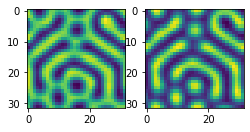

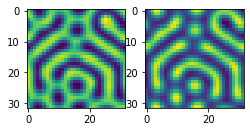

In [138]:
start = 0
plt.subplot(131)
plt.imshow(a_2[(start*N):((start+1)*N), :].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(s_2[(start*N):((start+1)*N), :].reshape((x_size,y_size)))
plt.show()

plt.subplot(131)
plt.imshow(data[0, :, :, -1].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(data[1, :, :, -1].reshape((x_size,y_size)))
plt.show()



In [59]:
T

32

In [96]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
XX_2 = X_2.flatten()# N 
YY_2 = Y_2.flatten()# N 

index = 500#-1
t_test = 25000#t_star[index]#0#5000000


TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [97]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
#a_2, s_2 = model.predict(x, y, t)
a_2 = a_2.reshape((x_size,y_size))
s_2 = s_2.reshape((x_size,y_size))
#c = np.stack((a_2, s_2), axis=0)
#c = c[:, np.newaxis]
#a_2_interp, s_2_interp = rdsolver.viz.interpolate_concs(c)
tf_dict = {model.x_tf: x_2, model.y_tf: y_2, model.t_tf: t_2, 
           model.a_tf:data[0, :, :, index].flatten()[:, np.newaxis],
           model.s_tf:data[1, :, :, index].flatten()[:, np.newaxis]}
print( f"Loss_a : {model.sess.run(model.loss_a, tf_dict):.8f}")
print( f"Loss_s : {model.sess.run(model.loss_s, tf_dict):.8f}")
print( f"Loss   : {model.sess.run(model.loss, tf_dict):.8f}")

Loss_a : 0.00000008
Loss_s : 0.00005015
Loss   : 48.38435745


In [98]:
print(np.sum(np.power(a_2 - data[0, :, :, index],2)))
print(np.sum(np.power(s_2 - data[1, :, :, index],2)))

44.568421832960176
3.815885208497169


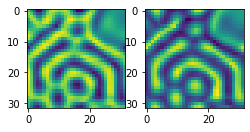

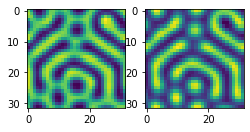

In [99]:

plt.subplot(131)
plt.imshow(a_2)
plt.subplot(132)
plt.imshow(s_2)
plt.show()

plt.subplot(131)
plt.imshow(data[0, :, :, index].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(data[1, :, :, index].reshape((x_size,y_size)))
plt.show()

In [363]:
saver = tf.train.Saver()
saver.save(model.sess, './PINN_Turring_model_loss_full_32_steps', global_step=0)

'./PINN_Turring_model_loss_full_32_steps-0'

In [364]:
print(model.x_tf.name)
print(model.y_tf.name)
print(model.t_tf.name)
print(model.a_pred.name)
print(model.s_pred.name)
print(model.loss_1.name)
print(model.loss_a.name)
print(model.loss_s.name)

x_tf_19:0
y_tf_19:0
t_tf_19:0
a_pred_19:0
s_pred_19:0
add_253:0
loss_a_19:0
loss_s_19:0
